# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 5
# Logistic Regression and PCA 

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): **Chia Chi Ho (Michelle Ho)**

Enrollment Status (109A, 121A, 209A, or E109A): **209A**

---
**Note: in this HW, to be consistent, I specify Cancer_type=0 to denote ALL, and Cancer_type=1 to denote AML. **

---


Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
%matplotlib inline



/Users/jasminetong/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Cancer Classification from Gene Expressions

In this homework assignment, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following parts, we will use logistic regression to build a classification model for this data set. We will also use principal components analysis (PCA) to visualize the data and to reduce its dimensions. 



## Part (a): Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peak at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. A convenient tool to visualize the gene expression data is a heat map. Arrange the rows of the training set so that the 'AML' rows are grouped together and the 'ALL' rows are together. Generate a heat map of the data with expression values from the following genes: 
`D49818_at`, `M23161_at`, `hum_alu_at`, `AFFX-PheX-5_at`, `M15990_at`. By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.

5. We can also visualize this data set in two dimensions using PCA. Find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the AML and ALL points in different colors. How well do the top two principal components discriminate between the two classes?



In [2]:
np.random.seed(9001)
df = pd.read_csv('dataset_hw5.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

In [3]:
all_predictors = list(data_train.columns)
all_predictors.remove('Cancer_type')
len(all_predictors)

7129

In [4]:
# Standardize test and train data
df_train = pd.DataFrame()
df_test = pd.DataFrame()
for p in data_train.columns:
    if (not np.logical_or((data_train[p]==0), ((data_train[p]==1))).all()): # standardize if continuous variable
        df_train[p] = (data_train[p] - data_train[p].mean())/data_train[p].std()
        df_test[p] = (data_test[p] - data_train[p].mean())/data_train[p].std()
    else:
        df_train[p] = data_train[p] # append to dataframes w/o normalization if not continuous 
        df_test[p] = data_test[p]

In [5]:
df_train.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,-0.779208,0.165303,-0.440211,-0.832435,-0.242254,-1.006038,0.856866,0.286845,1.642969,...,0.459604,-0.352156,-1.091470,0.392367,0.188727,0.116657,0.096927,0.630846,-0.452910,0.049965
5,0,0.511878,0.974951,0.552011,-1.432645,0.625746,0.504626,-0.198711,0.824852,-0.868608,...,-1.418218,-1.228870,0.894241,-0.594481,0.655948,-1.028804,-1.014114,0.126619,-0.784603,-0.831473
9,0,-3.080327,-0.644345,-0.160712,1.196848,-1.050392,0.048213,0.095207,0.638196,0.120202,...,1.227180,1.795336,1.613390,-0.285775,1.694218,2.188526,3.102138,1.081049,0.121109,-0.892969
12,0,1.249642,-0.860251,0.517074,0.406095,0.004677,-0.016071,1.255077,0.012352,-0.789503,...,1.007873,1.202714,-0.919733,-0.518570,-0.053536,1.579287,-0.188549,0.936984,0.155481,0.480435
13,0,-0.164405,-0.455427,-1.131972,-0.413240,0.835263,0.350345,-0.144984,1.955763,0.397069,...,-0.664348,-0.095557,0.121424,-1.394081,1.278910,-1.218193,-0.736354,-0.161510,-0.743356,0.357444


In [6]:
df_test.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,0,-0.085359,0.691574,1.816745,-1.556498,-1.170117,-1.179603,0.727289,-0.558593,-0.364315,...,1.213473,0.637584,2.590145,-0.695696,-1.074501,-0.262121,-0.516460,-0.917850,-0.564620,-1.056958
2,0,0.169345,0.543139,-0.565986,-0.070263,0.244125,0.755332,0.240586,0.879750,-0.156665,...,0.062109,0.069400,0.862040,0.974354,0.379076,-1.122358,0.039060,0.234668,-0.684923,0.295948
3,0,0.467964,0.286750,1.628083,-1.146830,-1.020461,-0.961039,0.641958,0.253906,0.397069,...,-1.664939,0.588708,-1.660349,-0.812094,0.517512,0.908440,0.687167,0.162636,-0.146996,-0.052528
4,0,-2.527004,-1.278569,0.013975,-1.689878,-2.083013,-2.497416,-0.641168,-2.864335,-0.156665,...,1.885103,0.008305,-0.672861,-0.047919,1.226997,2.409861,0.548287,1.045033,0.561075,1.218384
6,0,0.292306,0.624104,-0.251549,-0.022627,0.221677,1.121748,0.073084,1.538534,-0.720286,...,0.843392,-0.132214,0.282427,1.105934,0.154118,-0.104677,-0.007233,0.414749,-0.653988,0.582928


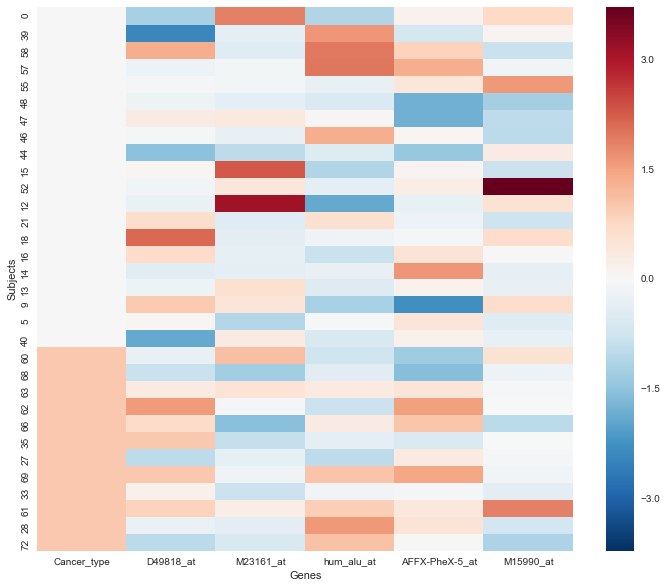

In [9]:
# sort dataframes by cancer_type
df_train.sort_values(['Cancer_type'], axis=0, inplace=True)
genes = ['Cancer_type','D49818_at', 'M23161_at', 'hum_alu_at', 'AFFX-PheX-5_at', 'M15990_at']

# visualize heatmap
fig1, ax1 = plt.subplots(1,1, figsize=(12,10))
ax1 = sns.heatmap(df_train[genes])
ax1.set_xlabel("Genes")
ax1.set_ylabel("Subjects")

In [10]:
# Find first 2 PCA component
X_train = df_train[all_predictors]
y_train = df_train["Cancer_type"]

X_test = df_test[all_predictors]
y_test = df_test["Cancer_type"]

pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.fit_transform(X_train)

print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [ 0.16803525  0.11170436]


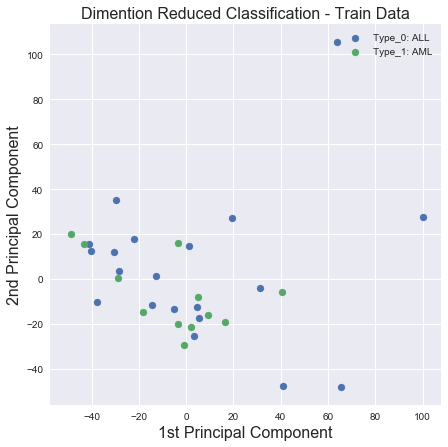

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.scatter(X_train_pca[y_train==0][:, 0], X_train_pca[y_train==0][:, 1], label='Type_0: ALL')
ax.scatter(X_train_pca[y_train==1][:, 0], X_train_pca[y_train==1][:, 1], label='Type_1: AML')

ax.set_title('Dimention Reduced Classification - Train Data', fontsize=16)
ax.set_xlabel('1st Principal Component', fontsize=16)
ax.set_ylabel('2nd Principal Component', fontsize=16)
ax.legend()

## Answers for Part (a)

Do you foresee a problem in fitting a classification model to such a data set (training set contains more predictors than observations)?

> **The problem in fitting a model to a data set with more predictors than observations is known as the curse of dimensionality. This problem arises because the data become sparse as dimensionality increases, thus we do not have enough information to reliably infer a relationship between the response and the predictors. In addition, increasing model complexity to arbitrarily high levels (e.g. when p >> n) often invovles adding noise feaures that are not truly associated with the response that will lead to overfitting and a worse fitted model than only including those predictors that have a true relationship with the response. **

By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.

> **Genes that are useful in discriminating between two classes have disparate values/patterns in each class. By observing the heat map, none of the genes are extermely useful in discriminating between the two class, but `M23161_at` is perhaps the most useful because it has more positive values for Cancer_type = 0 and more negative values for Cancer_type = 1. **

How well do the top two principal components discriminate between the two classes?

> **By visualizing the training data set in two dimensions using the first 2 principle components, there is no obvious boundary between the two cancer type. Hence, the first 2 principle components do not appear to be useful in discriminating between the two classes.**

## Part (b): Linear Regression vs. Logistic Regression

Begin by analyzing the differences between using linear regression and logistic regression for classification. For this part, you shall work with a single gene predictor: `D29963_at`.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by regression model interpreted for a patient as an estimate of the probability that the patient has the `ALL` type cancer (class 1). Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into the `ALL` type (class 1), and the others into the `AML` type (class 0). Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How does the training and test calssification accuracy of this model compare with the linear regression model?  Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order not to regularize (use 'C=100000').

4. Plot the quantitative output from linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot.
Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.



In [12]:
# Simple linear regression with X = D29963_at
X_train_simple_ones = sm.add_constant(df_train['D29963_at'])
X_test_simple_ones = sm.add_constant(df_test['D29963_at'])

simple_regr = sm.OLS(y_train, X_train_simple_ones).fit()

y_hat_train_simple = simple_regr.predict(X_train_simple_ones)
y_hat_test_simple = simple_regr.predict(X_test_simple_ones)

In [13]:
# Turn predicted score into classification criterion
def classify(y):
    if y > 0.5:
        return 1
    else:
        return 0

y_hat_train_simple_cls = [classify(x) for x in y_hat_train_simple]
y_hat_test_simple_cls = [classify(x) for x in y_hat_test_simple]


# Calculate classification errors
score_train_simple_cls = accuracy_score(y_train, y_hat_train_simple_cls)
score_test_simple_cls = accuracy_score(y_test, y_hat_test_simple_cls)

print("The accuracy of simple linear classification on TRAINING DATA is: {}".format(score_train_simple_cls))
print("The accuracy of simple linear classification on TEST DATA is: {}".format(score_test_simple_cls))


The accuracy of simple linear classification on TRAINING DATA is: 0.71875
The accuracy of simple linear classification on TEST DATA is: 0.8292682926829268


In [14]:
# Simple Logistic Regression
X_train_simple = df_train['D29963_at'].reshape(-1,1)
X_test_simple = df_test['D29963_at'].reshape(-1,1)

simple_log_regr = LogisticRegression(C=100000)
simple_log_regr.fit(X_train_simple, y_train)

score_train_simple_log = simple_log_regr.score(X_train_simple, y_train)
score_test_simple_log = simple_log_regr.score(X_test_simple, y_test)

print("The accuracy of simple logistic regression on TRAINING DATA is: {}".format(score_train_simple_log))
print("The accuracy of simple logistic regression on TEST DATA is: {}".format(score_test_simple_log))


The accuracy of simple logistic regression on TRAINING DATA is: 0.71875
The accuracy of simple logistic regression on TEST DATA is: 0.8292682926829268


/Users/jasminetong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/Users/jasminetong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


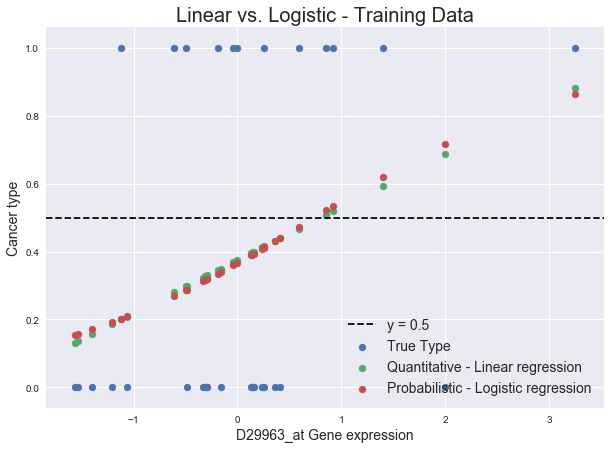

In [15]:
# plot quantitative output vs probabilistic output
fig, ax = plt.subplots(1, 1, figsize=(10,7))
# true labels
ax.scatter(x=df_train['D29963_at'], y=df_train['Cancer_type'], label="True Type")
# quantitative output from simple linear regression
ax.scatter(x=df_train['D29963_at'], y=y_hat_train_simple, label="Quantitative - Linear regression")
# probabilistic output from logistic regression
ax.scatter(x=df_train['D29963_at'], y=simple_log_regr.predict_proba(X_train_simple)[:,1], label="Probabilistic - Logistic regression")

ax.axhline(y=0.5, color='k', linestyle='--', label="y = 0.5")

ax.set_xlabel("D29963_at Gene expression", fontsize=14)
ax.set_ylabel("Cancer type", fontsize=14)
ax.set_title("Linear vs. Logistic - Training Data", fontsize=20)
ax.legend(fontsize=14)

## Answers to Part (b)

Fit a simple linear regression model to the training set using the single gene predictor D29963_at. We could interpret the scores predicted by regression model interpreted for a patient as an estimate of the probability that the patient has the type_1 cancer. Is there a problem with this interpretation?

> **The predicted values by the simple linear regression model can take on values that are larger than 1 or smaller than 0. These are invalid probability values.** 

Evaluate the classification accuracy of the **obtained classification model (from regression)** on both the training and test sets.

> **Simple linear regression classification model**
- Accuracy on TRAINING set: 0.71875
- Accuracy on TEST set: 0.8292682926829268

The classification accuracy of the **simple logistic regression model**

> **Simple logistic regression model**
- Accuracy on TRAINING set: 0.71875
- Accuracy on TRAINING set: 0.8292682926829268

How does the training and test calssification accuracy of this model compare with the linear regression model?

> **They gave the same training and test classification accuracies.**

Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

> **Although the two models gave the same training and test accuracies, logistic regression appears better suited for binary classification based on the plot. This is because the curve for logistic regression asymptotically approaches 1 to the right and approaches 0 to the left, bounding the possible predicted outcomes to 0 and 1 (which is binary). On the other hand, the linear line for linear regression monotonically increases to approach infinity (> 1) to the right and decreases to approach negative infinity (< 0) to the left. This is not ideal for binary classification as predictions can potentially take on values beyond [0, 1].**


## Part (c): Multiple Logistic Regression

1. Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?  

2. "Use the `visualize_prob` from `HW5_functions.py` to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the `ALL` and `AML` classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line.  Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?"

In [16]:
# Fit a multiple logistic regression model with all gene predictors
log_regr = LogisticRegression(C=100000)
log_regr.fit(X_train, y_train)

score_train_log = log_regr.score(X_train, y_train)
score_test_log = log_regr.score(X_test, y_test)

print("The accuracy of logistic regression using all predictors on TRAINING DATA is: {}".format(score_train_log))
print("The accuracy of logistic regression using all predictors on TEST DATA is: {}".format(score_test_log))


The accuracy of logistic regression using all predictors on TRAINING DATA is: 1.0
The accuracy of logistic regression using all predictors on TEST DATA is: 0.975609756097561


In [17]:
# Provided codes --- HW5_functions.py
import numpy as np

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    # Separate the predictions by types
    ypos = y_pred[y==1] # Cancer_type labeled 1: AML
    yneg = y_pred[y==0] # Cancer_type labeled 0: ALL
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'Type_1: AML')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'Type_0: ALL')
    
    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of Type_1:AML class', fontsize=16)
    ax.legend(loc = 'best', fontsize=14)
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])

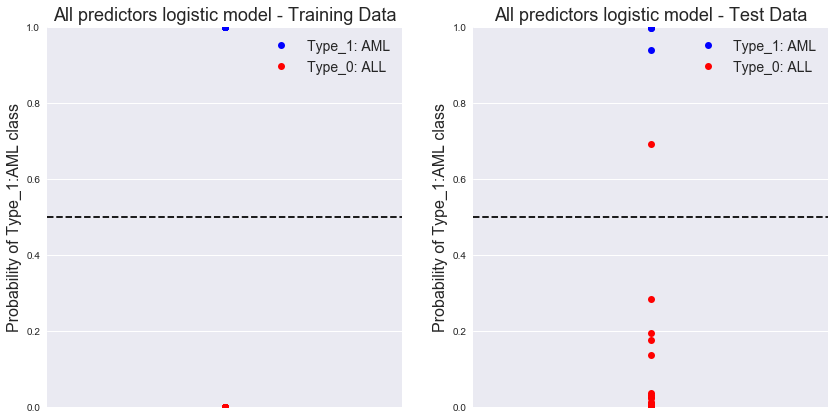

In [18]:
# visualize probability
fig4, axarr4 = plt.subplots(1, 2, figsize=(14 ,7))
visualize_prob(log_regr, X_train, y_train, axarr4[0])
visualize_prob(log_regr, X_test, y_test, axarr4[1])

axarr4[0].set_title("All predictors logistic model - Training Data", fontsize=18)
axarr4[1].set_title("All predictors logistic model - Test Data", fontsize=18)

## Answers to Part (c)

Fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?  

> Accuracy on TRAINING set -- 
- **Multiple Logistic Regression**: 1.0
- **Compare**: Simple single gene logistic: 0.71875

> Accuracy on TEST set -- 
- **Multiple Logistic Regression**: 0.975609756097561  
- **Compare**: Simple single gene logistic: 0.8292682926829268

> ** From the above accuracy values, multiple logistic regression using all the gene predictors performed better on both the training and test data sets compared to simple logistic regression with a single gene.** 

Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?"

> ** Yes, there is a difference in the spread of probabilities: There is more spread in the test plot. There are a couple points in the test setfor which the predicted probability is closer to 0.5. These points are more likely to be wrongly classified as they are closer to the decision boundary.**

## Part (d): Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 100 boostrap samples/iterations.  



In [19]:
# copied from HW4 provided code
# A function to select a random sample of size k from the training set
def sample(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x.iloc[subset_ind]
    y_subset = y.iloc[subset_ind]
    
    return (x_subset, y_subset)


# Compute betas for 100 trials
n_trials = 100
X_train_size = X_train.shape[0]

betas = np.zeros((n_trials, len(all_predictors)+1))
for i in range(n_trials):
    X_train_sample, y_train_sample = sample(X_train, y_train, X_train_size) # Bootstrap to get training samples
    
    log_regr_sample = LogisticRegression(C=100000)
    log_regr_sample.fit(X_train_sample, y_train_sample)
    
    betas[i, 0] = log_regr_sample.intercept_[0]
    betas[i, 1:] = log_regr_sample.coef_[0]

# Compute significant coeffs
sig_beta_idx = []
for j in range(len(all_predictors)+1):
#     sorted_betas_j = np.sort(np.array(betas[:,j]))
    beta_lower = np.percentile(betas[:,j], 2.5)
    beta_upper = np.percentile(betas[:,j], 97.5)
    if (np.sign(beta_upper) == np.sign(beta_lower)): # confidence interval does not contain 0
        sig_beta_idx.append(j) 
#     if (np.sign(sorted_betas_j[1]) == np.sign(sorted_betas_j[97])):
#         sig_beta_idx.append(j) 

print('We identified {} significant predictors using the bootstrap method.'.format(len(sig_beta_idx)))

We identified 1367 significant predictors using the bootstrap method.


In [20]:
X_names = ['const']+all_predictors
sig_X = []
for idx in sig_beta_idx:
    sig_X.append(X_names[idx])
sig_X[:20] # print out the first 20 selected significant genes

['const',
 'AFFX-CreX-5_at',
 'AFFX-BioB-3_st',
 'AFFX-ThrX-M_at',
 'AFFX-HUMTFRR/M11507_M_at',
 'AB000905_at',
 'AB002315_at',
 'AB002559_at',
 'AB003102_at',
 'AC000061_cds2_at',
 'AC000064_cds1_at',
 'AC002077_at',
 'AF000234_at',
 'AF001294_at',
 'AF002020_at',
 'AF009426_at',
 'AF010193_at',
 'AF015950_at',
 'AJ001047_at',
 'D00017_at']

In [21]:
sig_P = sig_X[1:]
sig_P_train = df_train[sig_P]
sig_P_test = df_test[sig_P]

sig_log_regr_2 = LogisticRegression(C=100000)
sig_log_regr_2.fit(sig_P_train, y_train)

score_train_sig_P_log = sig_log_regr_2.score(sig_P_train, y_train)
score_test_sig_P_log = sig_log_regr_2.score(sig_P_test, y_test)

print("The accuracy of logistic regression with only significant predictors on TRAINING DATA is: {}".format(score_train_sig_P_log))
print("The accuracy of logistic regression with only significant predictors on TEST DATA is: {}".format(score_test_sig_P_log))

The accuracy of logistic regression with only significant predictors on TRAINING DATA is: 1.0
The accuracy of logistic regression with only significant predictors on TEST DATA is: 1.0


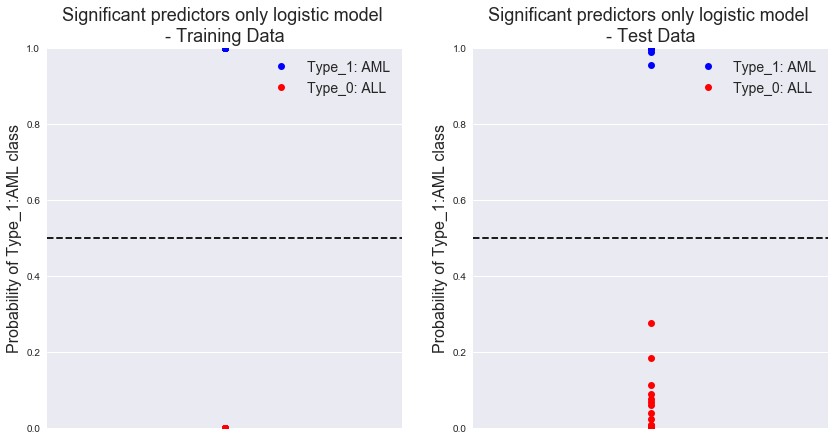

In [22]:
# visualize probability
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
visualize_prob(sig_log_regr_2, sig_P_train, y_train, ax[0])
visualize_prob(sig_log_regr_2, sig_P_test, y_test, ax[1])

ax[0].set_title("Significant predictors only logistic model \n- Training Data", fontsize=18)
ax[1].set_title("Significant predictors only logistic model \n- Test Data", fontsize=18)

## Answers to part (d)

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a significance level of 95%?

> **Approach: See whether the 95% confidence interval of betas got from bootstrapping contains zero. If zero is in the interval (for each beta, the 2nd least value and the 2nd largest value from the 100 trials have different sign), then the beta is not significant. If not, the beta is significant.**

> **As printed above, we identified around 1100 (first time running this notebook: 1136 ) significant predictors using the bootstrap method.**

## Part (e): Dimensionality Reduction using PCA

A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the first set of principal components contributing to 90% of the variance in the predictors.

1. How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?  

2. Re-fit a logistic regression model using 5-fold cross-validation to choose the number of principal components, and comment on whether you get better test performance than the model fitted above (explain your observations). 

3. Use the code provided in Part (c) to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)? 


In [23]:
n_pca = 1
pca_model = PCA(n_components=n_pca)
pca_model.fit(X_train)
X_train_pca_model = pca_model.fit_transform(X_train)
explained_var_sum = sum(pca_model.explained_variance_ratio_)

while explained_var_sum<0.9:
    n_pca += 1
    pca_model = PCA(n_components=n_pca)
    pca_model.fit(X_train)
    X_train_pca_model = pca_model.fit_transform(X_train)
    explained_var_sum = sum(pca_model.explained_variance_ratio_)

print('Number of Components: ', n_pca)
print('Total explained_variance_ratio_ Train: ',sum(pca_model.explained_variance_ratio_))

Number of Components:  24
Total explained_variance_ratio_ Train:  0.911484316071


In [24]:
X_test_pca_model = pca_model.fit_transform(X_test)

pca_log_regr = LogisticRegression(C=100000)
pca_log_regr.fit(X_train_pca_model, y_train)

score_train_pca_log = pca_log_regr.score(X_train_pca_model, y_train)
score_test_pca_log = pca_log_regr.score(X_test_pca_model, y_test)

print("The accuracy of PCA logistic regression on TRAINING DATA is: {}".format(score_train_pca_log))
print("The accuracy of PCA logistic regression on TEST DATA is: {}".format(score_test_pca_log))

The accuracy of PCA logistic regression on TRAINING DATA is: 1.0
The accuracy of PCA logistic regression on TEST DATA is: 0.43902439024390244


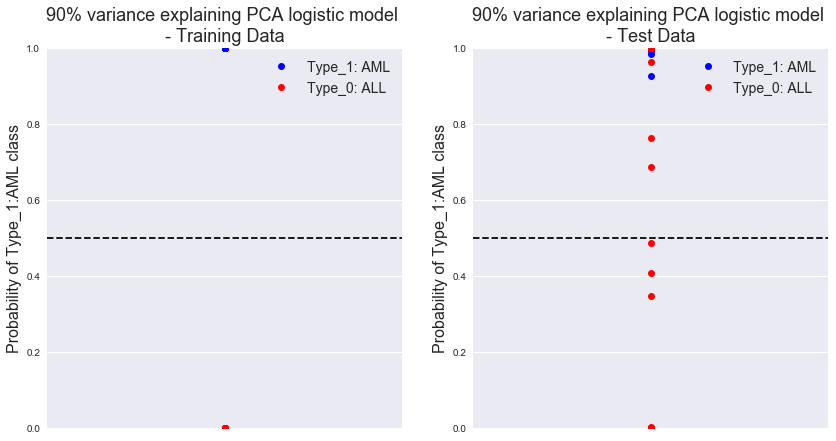

In [25]:
# visualize probability - the 1st set of PCA components (n=24) contributing to 90% of the predictors variance
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
visualize_prob(pca_log_regr, X_train_pca_model, y_train, ax[0])
visualize_prob(pca_log_regr, X_test_pca_model, y_test, ax[1])

ax[0].set_title("90% variance explaining PCA logistic model \n- Training Data", fontsize=18)
ax[1].set_title("90% variance explaining PCA logistic model \n- Test Data", fontsize=18)

In [24]:
# cross-validation 
# pca_cv = PCA()
# n_components = np.arange(1, 10)
# pca_scores = []
# fold = 5
# log_regr_pca_cv = LogisticRegression(C=100000)


# for i, n in enumerate(n_components):
#     # specify n PCA component
#     pca_cv.n_components = n
#     X_train_pca_cv = pca_cv.fit_transform(X_train.values)
#     pca_scores.append(np.mean(cross_val_score(log_regr_pca_cv, X=X_train_pca_cv, y=y_train, cv=fold, scoring='accuracy')))

# best_n = pca_scores.index(np.max(pca_scores)) + 1
# best_accuracy = np.max(pca_scores)
# print("The best model has n = {} PCA components with model accuracy on the TRAINING DATA = {}".format(best_n, best_accuracy))

The best model has n = 4 PCA components with model accuracy on the TRAINING DATA = 0.8428571428571429


In [27]:
X_train.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-0.779208,0.165303,-0.440211,-0.832435,-0.242254,-1.006038,0.856866,0.286845,1.642969,0.641133,...,0.459604,-0.352156,-1.091470,0.392367,0.188727,0.116657,0.096927,0.630846,-0.452910,0.049965
39,-1.903419,-0.468921,0.251549,1.454081,0.289022,-0.163923,-1.845283,-0.986803,0.505838,-0.983826,...,1.720622,1.211878,0.969376,-0.493266,-1.507113,0.757841,0.660163,0.846943,-0.492438,-0.626488
58,0.994938,-0.091085,0.048912,-0.032154,0.940022,1.263172,1.359370,1.077385,-1.096034,0.367212,...,0.596671,0.903348,0.819106,-0.047919,-0.520757,-0.157159,-0.369865,-1.241996,-0.392758,2.407301
57,0.265957,0.637598,0.377324,0.901506,0.251608,0.118925,0.771535,0.166068,0.980467,0.413639,...,0.747445,0.225193,-0.404521,0.351881,-0.987978,0.744150,0.417123,-0.791794,0.425304,1.177387
55,0.432832,0.907480,-1.104022,0.587111,0.356366,1.796725,0.013037,0.923669,-0.789503,0.650419,...,0.377363,-0.394922,0.582967,-0.356625,0.482903,-0.686535,-0.790363,-0.161510,-0.643676,0.562430


In [39]:
from sklearn.model_selection import KFold
nnn_pca = 30

accuracy_train_cv = np.zeros((nnn_pca,5))
accuracy_valid_cv = np.zeros((nnn_pca,5))

fold_ctr = 0

for itrain, ivalid in KFold(n_splits=5, shuffle=True, random_state=9001).split(X_train.index):
    # in general though its good for creating consistent psets, don't put seeds into kfold split
    X_train_cv = X_train.iloc[itrain,:]
    y_train_cv = y_train.iloc[itrain]
    X_valid_cv = X_train.iloc[ivalid,:]
    y_valid_cv = y_train.iloc[ivalid]
    
    # pca
    pca = PCA()
    pca.fit(X_train_cv)
    X_train_pca_cv = pca.transform(X_train_cv)
    X_valid_pca_cv = pca.transform(X_valid_cv)
    
    for comp in range(1,nnn_pca+1):
        # fit logit
        logregcv = LogisticRegression(C=100000, fit_intercept=True)
        logregcv.fit(X_train_pca_cv[:,:comp], y_train_cv)
        
        # get predictions
        yhat_train_pca_cv = logregcv.predict(X_train_pca_cv[:,:comp])
        yhat_valid_pca_cv = logregcv.predict(X_valid_pca_cv[:,:comp])
        
        # get accuracy       
        accuracy_train_cv[comp-1,fold_ctr] = accuracy_score(y_train_cv, yhat_train_pca_cv)
        accuracy_valid_cv[comp-1,fold_ctr] = accuracy_score(y_valid_cv, yhat_valid_pca_cv)
        
    fold_ctr += 1


In [40]:
scores_train = np.mean(accuracy_train_cv, axis=1)[1:]
scores_valid = np.mean(accuracy_valid_cv, axis=1)[1:]
best_n = np.argmax(scores_valid)

In [41]:
pca = PCA()
pca.fit(X_train)

X_train_pca_best = pca.transform(X_train)[:,:best_n]
X_test_pca_best = pca.transform(X_test)[:,:best_n]

log_regr_pca_best = LogisticRegression(C=100000)
log_regr_pca_best.fit(X_train_pca_best, y_train)
score_train_log_pca_best = log_regr_pca_best.score(X_train_pca_best, y_train)
score_test_log_pca_best = log_regr_pca_best.score(X_test_pca_best, y_test)

print("The accuracy of best PCA logistic regression on TRAINING DATA is: {}".format(score_train_log_pca_best))
print("The accuracy of best PCA logistic regression on TEST DATA is: {}".format(score_test_log_pca_best))

The accuracy of best PCA logistic regression on TRAINING DATA is: 1.0
The accuracy of best PCA logistic regression on TEST DATA is: 0.9512195121951219


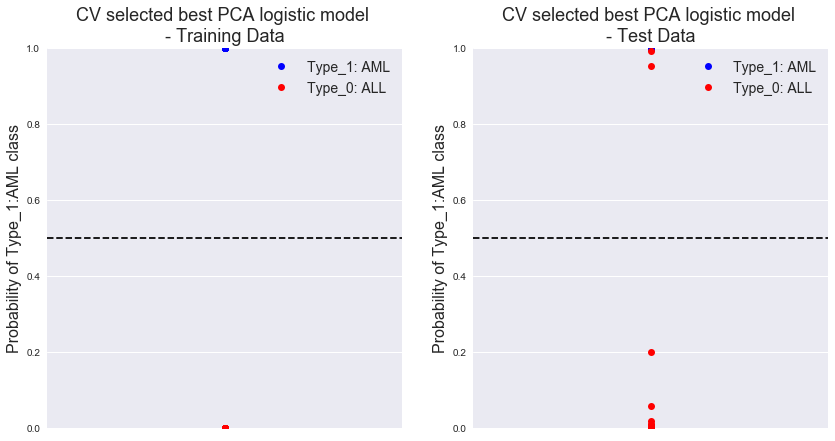

In [42]:
# visualize probability - CV selected best choice of PCA components (n=4) used 
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
visualize_prob(log_regr_pca_best, X_train_pca_best, y_train, ax[0])
visualize_prob(log_regr_pca_best, X_test_pca_best, y_test, ax[1])

ax[0].set_title("CV selected best PCA logistic model \n- Training Data", fontsize=18)
ax[1].set_title("CV selected best PCA logistic model \n- Test Data", fontsize=18)

## Answers to Part (e)

Fit the model on PCA components mentioned above. How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?

> Accuracy on TRAINING set -- 
- **Part (b1) Simple single gene linear regression: ** 0.71875
- **Part (b2) Simple single gene logistic regression:** 0.8292682926829268
- **Part (c) Multiple logistic regression with all predictors:** 1.0
- **Part (d) Multiple losgistic regression with significant predictors:** 1.0
- **Part (e1) PCA explaining ~90% variance logstic regression:** 1.0

> Accuracy on TEST set -- 
- **Part (b1) Simple single gene linear regression: ** 0.71875
- **Part (b2) Simple single gene logistic regression:** 0.8292682926829268
- **Part (c) Multiple logistic regression with all predictors:** 0.975609756097561
- **Part (d) Multiple losgistic regression with significant predictors:** 1.0
- **Part (e1) PCA explaining ~90% variance logstic regression:** 0.43902439024390244

> **The PCA logistic model performed the same on the training set as models in parts (c) and (d) but performed worst on the test set. This is summarized above. **

Re-fit a logistic regression model using 5-fold cross-validation to choose the number of principal components that maximizes accuracy, and comment on whether you get better test performance than the model fitted above (explain your observations).

> Accuracy on TRAINING set -- 
- **Part (e1) PCA explaining ~90% variance logstic regression:** 1.0
- **Part (e2) Cross-validated PCA logistic regression:** 0.9375

> Accuracy on TEST set -- 
- **Part (e1) PCA explaining ~90% variance logstic regression:** 0.43902439024390244
- **Part (e2) Cross-validated PCA logistic regression:** 0.4878048780487805

> **Explanation: The cross-validated model has fewer numer of PCA components (n_component=4) compared to the model that captures at least 90% predictor variance (n_component=24). The former achieved a better test performance because the latter most likely had overfitted the training data.**

Use the code provided in Part (c) to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)?

>  ** The trend in the spread of probabilities from the cross-validated PCA model on the training and test sets is the reverse of the trend from the models in Part (c) and (d). The spread of the probabilities from the cross-validated PCA model is higher in the training set compared to the test set while the spread from the models in Part (c) and (d) is higher in the test set compared to the training set.**

---

# APCOMP209a - Homework Question

Suppose we want to conduct PCA on the model matrix $X \in \Re^{n×p}$, where the columns have been suitably set to zero mean. In this question, we consider the squared reconstruction error:

$$  \parallel XQ- XQ_m \parallel ^2 $$

for a suitable set of eigenvectors forming the matrix $Q_m$, as discussed below. Suppose that we conduct eigendecomposition of $X^T X$ and obtain eigenvalues $\lambda_1, \ldots , \lambda_p$ and principal components $Q$, i.e.

$$ X^T X = Q \Lambda Q ^T $$

(1) Suppose that the matrix norm is simply the squared dot product, namely

$$ \parallel A \parallel ^2 = A^T A $$

Then, express the reconstruction error as a sum of matrix products.


### Answer (1) 

> \begin{equation}
    \parallel XQ- XQ_m \parallel ^2 
                = (XQ- XQ_m)^T(XQ- XQ_m) 
                = (Q^TX^T-Q_m^TX^T)(XQ- XQ_m) 
                = Q^TX^TXQ - Q^TX^TXQ_m - Q_m^TX^TXQ + Q_M^TX^TXQ_m
 \end{equation}

---

(2) Simplify your result from (1) based on properties of the matrices $Q$.


### Answer (2) 

By plugging in $ X^T X = Q \Lambda Q ^T $, we get

> \begin{equation}
    \parallel XQ- XQ_m \parallel ^2 
                = Q^TQ \Lambda Q^TQ - Q^TQ \Lambda Q^TQ_m - Q_m^TQ \Lambda Q^TQ + Q_m^TQ \Lambda Q^TQ_m 
                = \Lambda - \Lambda Q^TQ_m - Q_m^TQ \Lambda + Q_m^TQ \Lambda Q^TQ_m
 \end{equation}

---

(3) Now let $Q_m$ be the matrix of the first $m < p$ eigenvectors, namely

$$ Q_m = (q_1, \ldots, q_m, 0, \ldots, 0) \in \Re^{p \times p} $$

Thus, $X Q_m$ is the PCA projection of the data into the space spanned by the first $m$ principal components. Express the products $Q^T_m Q$ and $Q^T Q_m$, again using properties of the eigenbasis $q_1, \ldots, q_p$.


### Answer (3) 

> \begin{equation}
Q^T_m Q = \begin{bmatrix}
q_1^T \\
\vdots \\
q_m^T \\
0 \\
\vdots \\
0
\end{bmatrix}
[q_1 , \ldots, q_m, q_{m+1}, \ldots, q_p] 
= \begin{bmatrix}
\parallel q_1 \parallel ^2 & 0 & \ldots & 0 & \ldots & 0 \\
0 & \parallel q_2 \parallel ^2 & \ldots & 0 & \ldots & 0 \\
0 & \ldots & \ldots & 0 & \ldots & 0\\
0 & \ldots &  \parallel q_m \parallel ^2 & 0 & \ldots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
0 & \ldots & \ldots & 0 & \ldots & 0
\end{bmatrix}
= \begin{bmatrix}
1 & 0 & \ldots & 0 & \ldots & 0 \\
0 & 1 & \ldots & 0 & \ldots & 0 \\
0 & \ldots & \ldots & 0 & \ldots & 0\\
0 & \ldots &  1 & 0 & \ldots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
0 & \ldots & \ldots & 0 & \ldots & 0
\end{bmatrix}
\end{equation}


> \begin{equation}
Q^T Q_m = \begin{bmatrix}
q_1^T \\
\vdots \\
q_m^T \\
q_{m+1}^T \\
\vdots \\
q_p^T
\end{bmatrix}
[q_1 , \ldots, q_m, 0, \ldots, 0] 
= \begin{bmatrix}
\parallel q_1 \parallel ^2 & 0 & \ldots & 0 & \ldots & 0 \\
0 & \parallel q_2 \parallel ^2 & \ldots & 0 & \ldots & 0 \\
0 & \ldots & \ldots & 0 & \ldots & 0\\
0 & \ldots &  \parallel q_m \parallel ^2 & 0 & \ldots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
0 & \ldots & \ldots & 0 & \ldots & 0
\end{bmatrix}
= \begin{bmatrix}
1 & 0 & \ldots & 0 & \ldots & 0 \\
0 & 1 & \ldots & 0 & \ldots & 0 \\
0 & \ldots & \ldots & 0 & \ldots & 0\\
0 & \ldots &  1 & 0 & \ldots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
0 & \ldots & \ldots & 0 & \ldots & 0
\end{bmatrix}
\end{equation}

---

(4) Use your results from (3) to finally fully simplify your expression from (2).


### Answer (4) 

> Simplified expression from (2):

> \begin{equation}
\parallel XQ- XQ_m \parallel ^2 
= \begin{bmatrix}
\lambda_1 & 0 & \ldots & 0 & \ldots & 0 \\
0 & \lambda_2 & \ldots & 0 & \ldots & 0 \\
0 & \ldots & \ldots & 0 & \ldots & 0\\
0 & \ldots &  \lambda_m & 0 & \ldots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
0 & \ldots & \ldots & 0 & \ldots & \lambda_p
\end{bmatrix} - 
2 \begin{bmatrix}
\lambda_1 & 0 & \ldots & 0 & \ldots & 0 \\
0 & \lambda_2 & \ldots & 0 & \ldots & 0 \\
0 & \ldots & \ldots & 0 & \ldots & 0\\
0 & \ldots &  \lambda_m & 0 & \ldots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
0 & \ldots & \ldots & 0 & \ldots & 0
\end{bmatrix} +
\begin{bmatrix}
\lambda_1 & 0 & \ldots & 0 & \ldots & 0 \\
0 & \lambda_2 & \ldots & 0 & \ldots & 0 \\
0 & \ldots & \ldots & 0 & \ldots & 0\\
0 & \ldots &  \lambda_m & 0 & \ldots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
0 & \ldots & \ldots & 0 & \ldots & 0
\end{bmatrix} \\
= \begin{bmatrix}
0 & \ldots & 0 & 0 & \ldots & 0 \\
\vdots & \quad & \vdots & \vdots & \quad & \vdots \\
0 & \ldots & 0 & 0 & \ldots & 0 \\
0 & \ldots & 0 & \lambda_{m+1} & \ldots & 0 \\
\vdots & \quad & \vdots & \vdots & \quad & \vdots \\
0 & \ldots & 0 & 0 & \ldots & \lambda_p
\end{bmatrix}
\end{equation}

---

(5) Note that the result you obtain should still be a matrix, i.e. this does not define a proper norm on the space of matrices (since the value should be a scalar). Consequently, the true matrix norm is actually the trace of the
above result, namely

$$ \parallel A \parallel ^2  = {\rm trace} (A^T A) $$
Use your result from (4) and this new definition to find a simple expression
for the reconstruction error in terms of the eigenvalues.


### Answer (5) 

> By the new definition of matrix norm using its trace, we can express the reconstruction error norm as:

> \begin{equation}
\parallel XQ- XQ_m \parallel ^2 = trace[(XQ- XQ_m)^T(XQ- XQ_m)]
= \Sigma_{i=m+1}^p \lambda_i
\end{equation}

---

(6) Interpret your result from (5). In light of your results, does our procedure for PCA (selecting the $m$ substantially larger eigenvalues) make sense? Why or why not?

### Answer (6)

> Giving reconstruction error $ = \Sigma_{i=m+1}^p \lambda_i$, PCA ignores the non-significant covariance terms from the $(m+1)^{th}$ and onwards. It make sense since the error is nothing more than the $p-m$ least significant eigenvalues.
